In [157]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Applying CRIPS-DM Methodology to a Business Problem

## Dataset 1 - Predicting Customer Churn in the Telecomunication Provider

## 3. Modeling

### 3.4. Random Forest

In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [159]:
X_train = pd.read_csv('../data/processed/SMOTE/X_train.csv')
y_train = pd.read_csv('../data/processed/SMOTE/y_train.csv')
X_val = pd.read_csv('../data/processed/SMOTE/X_val.csv')
y_val = pd.read_csv('../data/processed/SMOTE/y_val.csv')
X_test = pd.read_csv('../data/processed/SMOTE/X_test.csv')
y_test = pd.read_csv('../data/processed/SMOTE/y_test.csv')

In [160]:
y_train = y_train.values.ravel()
y_val = y_val.values.ravel()
y_test = y_test.values.ravel()

In [161]:
from sklearn.ensemble import RandomForestClassifier

In [162]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, classification_report, ConfusionMatrixDisplay
from joblib import dump

In [163]:
rf = RandomForestClassifier(random_state=8)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=8)

In [129]:
dump(tree, '../models/rf_reg_1.joblib')

['../models/rf_reg_1.joblib']

In [164]:
def random_forest(model):
    y_train_preds = model.predict(X_train)
    y_val_preds = model.predict(X_val)
    
    y_train_probs = model.predict_proba(X_train)[:, 1]
    y_val_probs = model.predict_proba(X_val)[:, 1]
    
    train_accuracy = accuracy_score(y_train, y_train_preds)
    train_precision = precision_score(y_train, y_train_preds)
    train_recall = recall_score(y_train, y_train_preds)
    train_f1 = f1_score(y_train, y_train_preds)
    train_roc_auc = roc_auc_score(y_train, y_train_probs)
    
    val_accuracy = accuracy_score(y_val, y_val_preds)
    val_precision = precision_score(y_val, y_val_preds)
    val_recall = recall_score(y_val, y_val_preds)
    val_f1 = f1_score(y_val, y_val_preds)
    val_roc_auc = roc_auc_score(y_val, y_val_probs)
    
    train_score = pd.DataFrame({
        'accuracy': train_accuracy,
        'precision': train_precision,
        'recall': train_recall,
        'f1-score': train_f1,
        'roc-auc': train_roc_auc}, index=['Training Set'])
    
    val_score = pd.DataFrame({
        'accuracy': val_accuracy,
        'precision': val_precision,
        'recall': val_recall,
        'f1-score': val_f1,
        'roc-auc': val_roc_auc}, index=['Validation Set'])

    score = pd.concat([train_score, val_score])
    print(score)
    
    
    ConfusionMatrixDisplay.from_estimator(model, X_train, y_train, normalize='true')
    ConfusionMatrixDisplay.from_estimator(model, X_val, y_val, normalize='true')                                     
    
    plt.figure()
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_probs)
    fpr_val, tpr_val, _ = roc_curve(y_val, y_val_probs)
    
    plt.plot(fpr_train, tpr_train, label='Train ROC-curve')
    plt.plot(fpr_val, tpr_val, label='Validate ROC-curve')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-Curve')
    plt.legend()
    
    plt.show()
    
    rf_val = pd.DataFrame({'accuracy': val_accuracy,
                             'precision': val_precision,
                             'recall': val_recall,
                             'f1-score': val_f1,
                             'roc-auc': val_roc_auc}, index=['Random Forest'])
    
    return(rf_val)

                accuracy  precision    recall  f1-score   roc-auc
Training Set    1.000000   1.000000  1.000000  1.000000  1.000000
Validation Set  0.888235   0.727273  0.333333  0.457143  0.793914


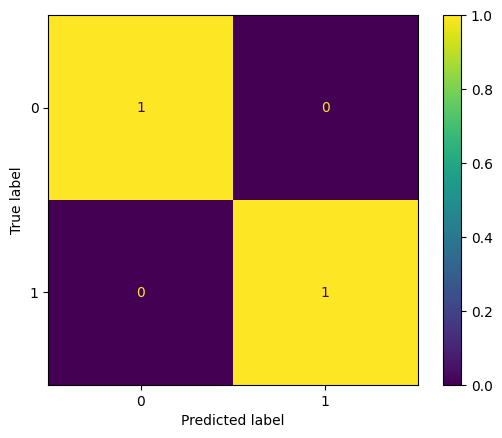

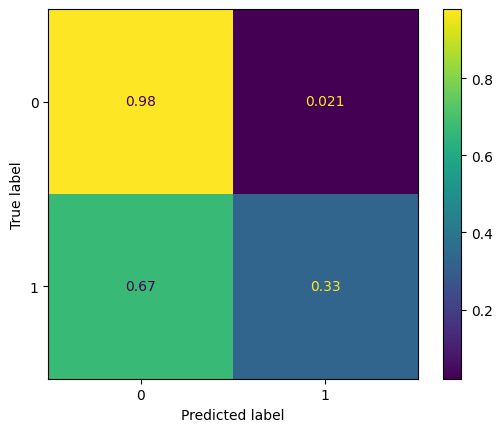

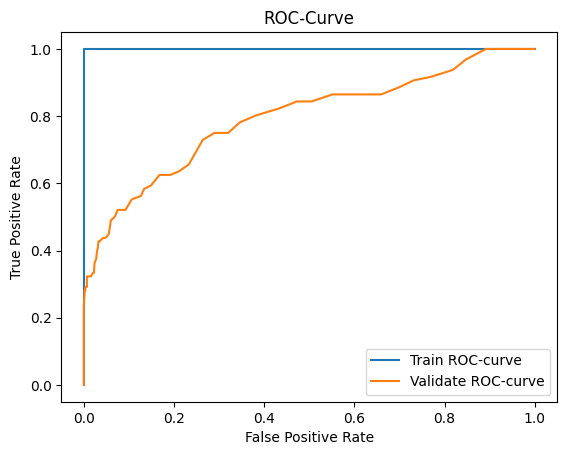

,accuracy,precision,recall,f1-score,roc-auc
Random Forest,0.888235,0.727273,0.333333,0.457143,0.793914


In [165]:
random_forest(rf)

The model perform really well on the training set, however it doesn't perform as effective to the validation set. There were a drop in all performance metrics suggesting that there might be an overfitting to the training data. We'll try to do the hyperparameter tuning to see if we can address this issues.

### Reduce Overfitting with n_estimators

default = 100

In [166]:
n_estimators = [2, 5, 10, 20, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]

In [167]:
train_accuracy = []
train_precision = []
train_recall = []
train_f1 = []
train_roc_auc = []

val_accuracy = []
val_precision = []
val_recall = []
val_f1 = []
val_roc_auc = []
    
for i in n_estimators:
    rf = RandomForestClassifier(random_state=8, n_estimators=i).fit(X_train, y_train)
    y_train_preds = rf.predict(X_train)
    y_val_preds = rf.predict(X_val)
    
    y_train_probs = rf.predict_proba(X_train)[:, 1]
    y_val_probs = rf.predict_proba(X_val)[:, 1]
        
    train_accuracy.append(accuracy_score(y_train, y_train_preds))
    train_precision.append(precision_score(y_train, y_train_preds))
    train_recall.append(recall_score(y_train, y_train_preds))
    train_f1.append(f1_score(y_train, y_train_preds))
    train_roc_auc.append(roc_auc_score(y_train, y_train_probs))
    
    val_accuracy.append(accuracy_score(y_val, y_val_preds))
    val_precision.append(precision_score(y_val, y_val_preds))
    val_recall.append(recall_score(y_val, y_val_preds))
    val_f1.append(f1_score(y_val, y_val_preds))
    val_roc_auc.append(roc_auc_score(y_val, y_val_probs))
    
tune_n_estimators = pd.DataFrame({'train_accuracy': train_accuracy,
                       'val_accuracy': val_accuracy,
                       'train_precision': train_precision,
                       'val_precision': val_precision,
                       'train_recall': train_recall,
                       'val_recall': val_recall,
                       'train_f1': train_f1,
                       'val_f1': val_f1,
                       'train_roc_auc': train_roc_auc,
                       'val_roc_auc': val_roc_auc}, index=n_estimators)

tune_n_estimators

,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_f1,val_f1,train_roc_auc,val_roc_auc
2,0.951027,0.858824,0.992527,0.500000,0.908896,0.239583,0.948873,0.323944,0.986480,0.603435
5,0.993798,0.851471,0.991905,0.469136,0.995723,0.395833,0.993810,0.429379,0.999392,0.725198
10,0.998075,0.888235,0.998715,0.700000,0.997434,0.364583,0.998074,0.479452,0.999986,0.769531
20,0.999358,0.888235,0.999572,0.717391,0.999145,0.343750,0.999358,0.464789,0.999999,0.809869
50,1.000000,0.894118,1.000000,0.772727,1.000000,0.354167,1.000000,0.485714,1.000000,0.808576
100,1.000000,0.888235,1.000000,0.727273,1.000000,0.333333,1.000000,0.457143,1.000000,0.793914
150,1.000000,0.888235,1.000000,0.738095,1.000000,0.322917,1.000000,0.449275,1.000000,0.794529
200,1.000000,0.889706,1.000000,0.756098,1.000000,0.322917,1.000000,0.452555,1.000000,0.800309
250,1.000000,0.892647,1.000000,0.767442,1.000000,0.343750,1.000000,0.474820,1.000000,0.801174
300,1.000000,0.889706,1.000000,0.756098,1.000000,0.322917,1.000000,0.452555,1.000000,0.809976


In [168]:
def plot_performance(parameter, xlabel):
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(16, 5))
    
    ax1.plot(parameter, train_accuracy, label='train accuracy')
    ax1.plot(parameter, val_accuracy, label='val accuracy')
    ax1.legend()
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel('accuracy')
    ax1.set_title('Accuracy Score')
    
    ax2.plot(parameter, train_precision, label='train precision')
    ax2.plot(parameter, val_precision, label='val precision')
    ax2.legend()
    ax2.set_xlabel(xlabel)
    ax2.set_ylabel('precision')
    ax2.set_title('Precision Score')
    
    ax3.plot(parameter, train_recall, label='train recall')
    ax3.plot(parameter, val_recall, label='val recall')
    ax3.legend()
    ax3.set_xlabel(xlabel)
    ax3.set_ylabel('recall')
    ax3.set_title('Recall Score')
    
    ax4.plot(parameter, train_f1, label='train f1')
    ax4.plot(parameter, val_f1, label='val f1')
    ax4.legend()
    ax4.set_xlabel(xlabel)
    ax4.set_ylabel('f1')
    ax4.set_title('F1-Score')
    
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_probs)
    fpr_val, tpr_val, _ = roc_curve(y_val, y_val_probs)
    
    ax5.plot(fpr_train, tpr_train, label='train roc-auc')
    ax5.plot(fpr_val, tpr_val, label='val roc-auc')
    ax5.legend()
    ax5.set_xlabel('false positive rate')
    ax5.set_ylabel('true positive rate')
    ax5.set_title('ROC-AUC Score')
    
    plt.subplots_adjust(wspace=0.4)
    plt.show()    

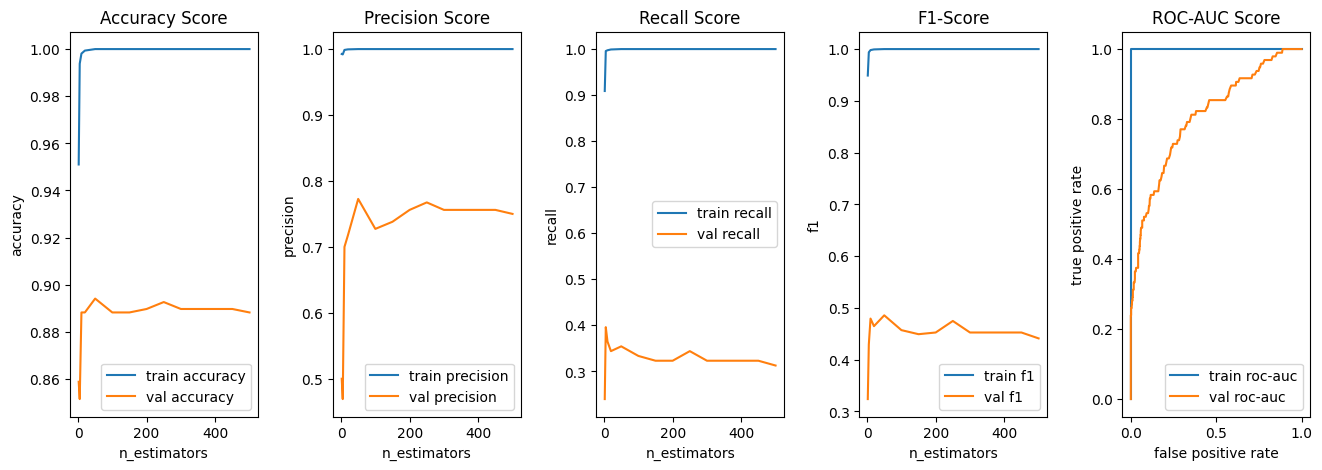

In [169]:
plot_performance(n_estimators, 'n_estimators')

### Reduce Overfitting with max_depth

default = None

In [171]:
max_depth = [2, 5, 10, 20, 50, 100, 150, 200, None]

In [172]:
train_accuracy = []
train_precision = []
train_recall = []
train_f1 = []
train_roc_auc = []

val_accuracy = []
val_precision = []
val_recall = []
val_f1 = []
val_roc_auc = []
    
for i in max_depth:
    rf = RandomForestClassifier(random_state=8, n_estimators=50, max_depth=i).fit(X_train, y_train)
    y_train_preds = rf.predict(X_train)
    y_val_preds = rf.predict(X_val)
    
    y_train_probs = rf.predict_proba(X_train)[:, 1]
    y_val_probs = rf.predict_proba(X_val)[:, 1]
        
    train_accuracy.append(accuracy_score(y_train, y_train_preds))
    train_precision.append(precision_score(y_train, y_train_preds))
    train_recall.append(recall_score(y_train, y_train_preds))
    train_f1.append(f1_score(y_train, y_train_preds))
    train_roc_auc.append(roc_auc_score(y_train, y_train_probs))
    
    val_accuracy.append(accuracy_score(y_val, y_val_preds))
    val_precision.append(precision_score(y_val, y_val_preds))
    val_recall.append(recall_score(y_val, y_val_preds))
    val_f1.append(f1_score(y_val, y_val_preds))
    val_roc_auc.append(roc_auc_score(y_val, y_val_probs))
    
tune_max_depth = pd.DataFrame({'train_accuracy': train_accuracy,
                       'val_accuracy': val_accuracy,
                       'train_precision': train_precision,
                       'val_precision': val_precision,
                       'train_recall': train_recall,
                       'val_recall': val_recall,
                       'train_f1': train_f1,
                       'val_f1': val_f1,
                       'train_roc_auc': train_roc_auc,
                       'val_roc_auc': val_roc_auc}, index=max_depth)

tune_max_depth

,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_f1,val_f1,train_roc_auc,val_roc_auc
2.0,0.743584,0.826471,0.884537,0.362500,0.560308,0.302083,0.686043,0.329545,0.854295,0.735864
5.0,0.844311,0.867647,0.931404,0.539474,0.743370,0.427083,0.826832,0.476744,0.936524,0.784978
10.0,0.977759,0.880882,0.986498,0.622951,0.968777,0.395833,0.977557,0.484076,0.998023,0.810449
20.0,1.000000,0.892647,1.000000,0.780488,1.000000,0.333333,1.000000,0.467153,1.000000,0.801887
50.0,1.000000,0.894118,1.000000,0.772727,1.000000,0.354167,1.000000,0.485714,1.000000,0.808576
100.0,1.000000,0.894118,1.000000,0.772727,1.000000,0.354167,1.000000,0.485714,1.000000,0.808576
150.0,1.000000,0.894118,1.000000,0.772727,1.000000,0.354167,1.000000,0.485714,1.000000,0.808576
200.0,1.000000,0.894118,1.000000,0.772727,1.000000,0.354167,1.000000,0.485714,1.000000,0.808576
NaN,1.000000,0.894118,1.000000,0.772727,1.000000,0.354167,1.000000,0.485714,1.000000,0.808576


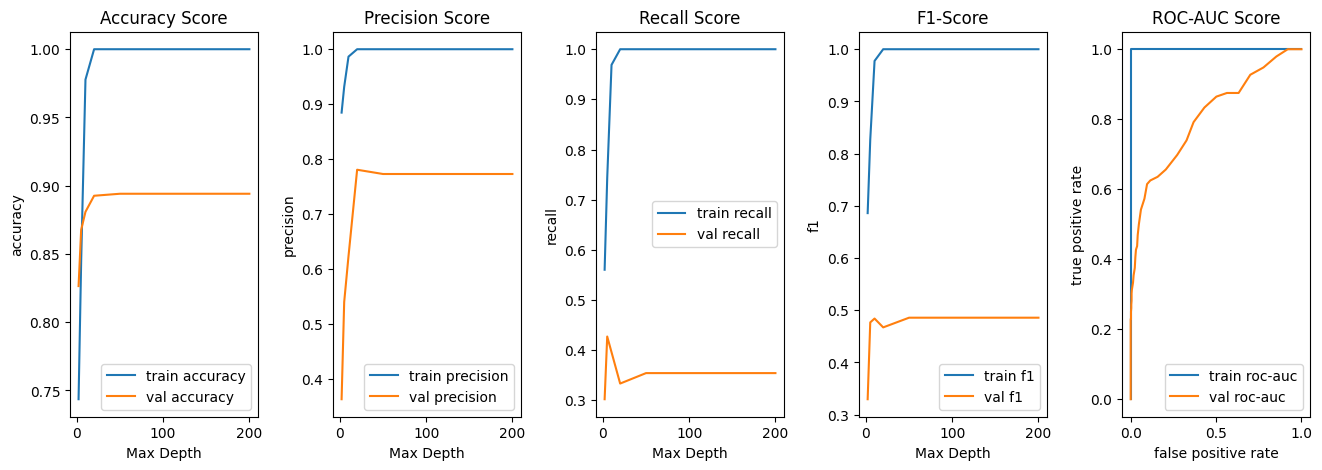

In [173]:
plot_performance(max_depth, 'Max Depth')

#### max_depth = 5

In [174]:
rf_max_depth = RandomForestClassifier(random_state=8, n_estimators=50, max_depth=5)
rf_max_depth.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, n_estimators=50, random_state=8)

                accuracy  precision    recall  f1-score   roc-auc
Training Set    0.844311   0.931404  0.743370  0.826832  0.936524
Validation Set  0.867647   0.539474  0.427083  0.476744  0.784978


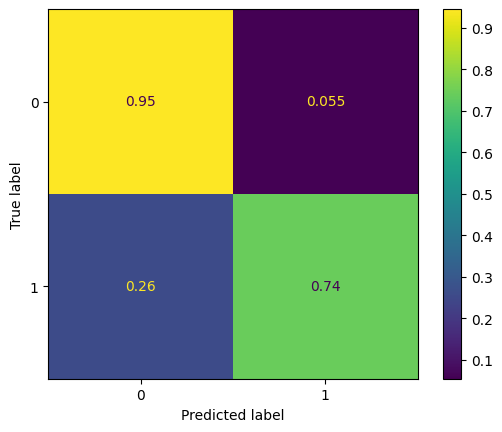

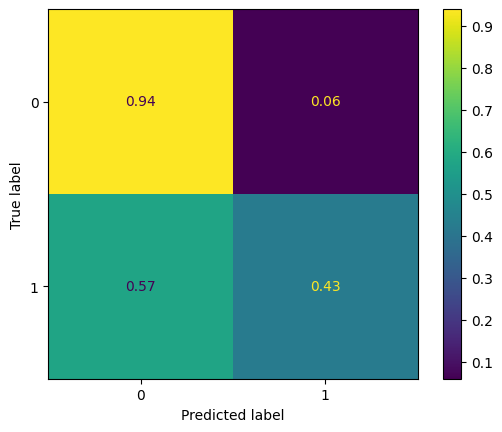

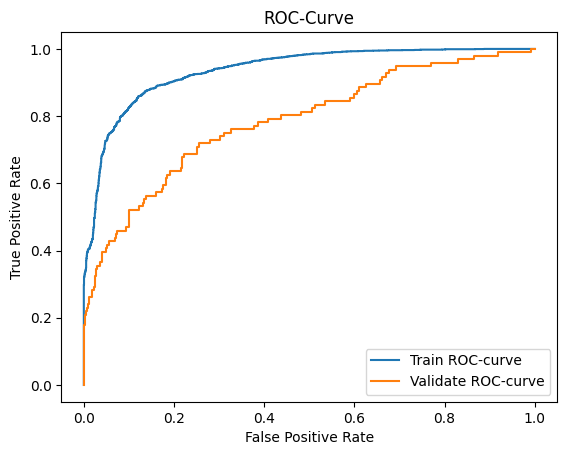

,accuracy,precision,recall,f1-score,roc-auc
Random Forest,0.867647,0.539474,0.427083,0.476744,0.784978


In [175]:
random_forest(rf_max_depth)

### Reduce Overfitting with min samples split

default = 2

In [84]:
min_samples_split = [2, 5, 10, 20, 50, 100, 150, 200]

In [176]:
train_accuracy = []
train_precision = []
train_recall = []
train_f1 = []
train_roc_auc = []

val_accuracy = []
val_precision = []
val_recall = []
val_f1 = []
val_roc_auc = []
    
for i in min_samples_split:
    rf = RandomForestClassifier(random_state=8, n_estimators=50, max_depth=5, min_samples_split=i).fit(X_train, y_train)
    y_train_preds = rf.predict(X_train)
    y_val_preds = rf.predict(X_val)
    
    y_train_probs = rf.predict_proba(X_train)[:, 1]
    y_val_probs = rf.predict_proba(X_val)[:, 1]
        
    train_accuracy.append(accuracy_score(y_train, y_train_preds))
    train_precision.append(precision_score(y_train, y_train_preds))
    train_recall.append(recall_score(y_train, y_train_preds))
    train_f1.append(f1_score(y_train, y_train_preds))
    train_roc_auc.append(roc_auc_score(y_train, y_train_probs))
    
    val_accuracy.append(accuracy_score(y_val, y_val_preds))
    val_precision.append(precision_score(y_val, y_val_preds))
    val_recall.append(recall_score(y_val, y_val_preds))
    val_f1.append(f1_score(y_val, y_val_preds))
    val_roc_auc.append(roc_auc_score(y_val, y_val_probs))
    
tune_min_samples_split = pd.DataFrame({'train_accuracy': train_accuracy,
                       'val_accuracy': val_accuracy,
                       'train_precision': train_precision,
                       'val_precision': val_precision,
                       'train_recall': train_recall,
                       'val_recall': val_recall,
                       'train_f1': train_f1,
                       'val_f1': val_f1,
                       'train_roc_auc': train_roc_auc,
                       'val_roc_auc': val_roc_auc}, index=min_samples_split)

tune_min_samples_split

,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_f1,val_f1,train_roc_auc,val_roc_auc
2,0.844311,0.867647,0.931404,0.539474,0.743370,0.427083,0.826832,0.476744,0.936524,0.784978
5,0.846236,0.861765,0.927177,0.512500,0.751497,0.427083,0.830144,0.465909,0.935644,0.785031
10,0.841959,0.860294,0.926400,0.506494,0.742943,0.406250,0.824591,0.450867,0.934758,0.776425
20,0.842814,0.850000,0.919414,0.465116,0.751497,0.416667,0.827018,0.439560,0.933009,0.792059
50,0.844311,0.860294,0.912398,0.506024,0.761762,0.437500,0.830303,0.469274,0.928967,0.784282
100,0.840462,0.864706,0.918947,0.525641,0.746792,0.427083,0.823974,0.471264,0.931432,0.785674
150,0.834046,0.852941,0.918094,0.474359,0.733533,0.385417,0.815502,0.425287,0.928209,0.783943
200,0.835971,0.850000,0.905106,0.465116,0.750642,0.416667,0.820669,0.439560,0.920560,0.780322
250,0.828272,0.851471,0.908028,0.470588,0.730539,0.416667,0.809671,0.441989,0.914851,0.779431
300,0.829769,0.851471,0.907075,0.471264,0.734816,0.427083,0.811909,0.448087,0.912786,0.781910


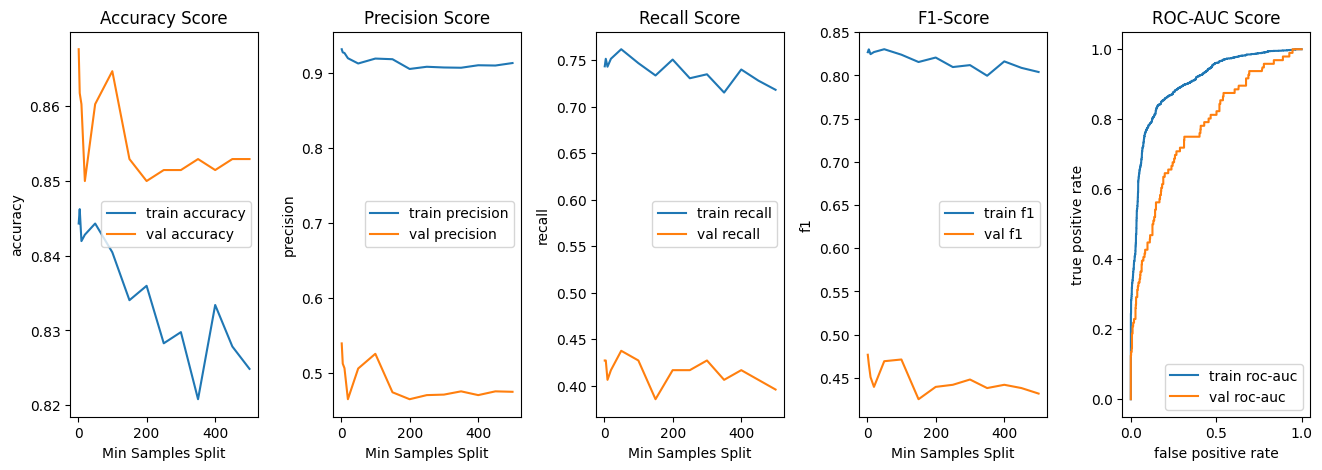

In [177]:
plot_performance(min_samples_split, 'Min Samples Split')

#### min_samples_split = 50

In [179]:
rf_min_samples_split = RandomForestClassifier(random_state=8, n_estimators=50, max_depth=5, min_samples_split=50)
rf_min_samples_split.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, min_samples_split=50, n_estimators=50,
                       random_state=8)

                accuracy  precision    recall  f1-score   roc-auc
Training Set    0.844311   0.912398  0.761762  0.830303  0.928967
Validation Set  0.860294   0.506024  0.437500  0.469274  0.784282


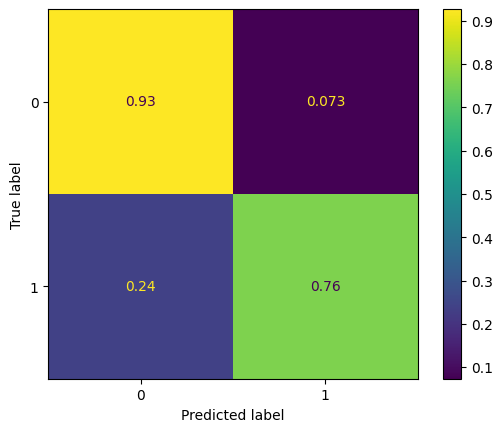

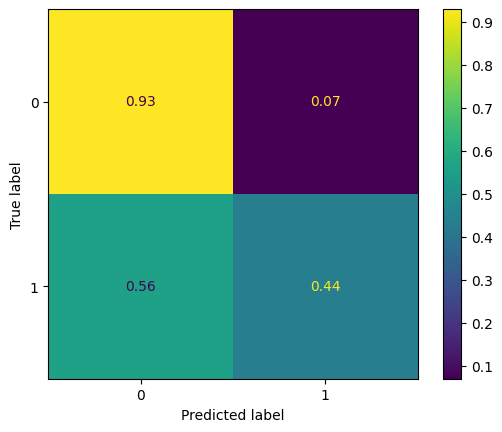

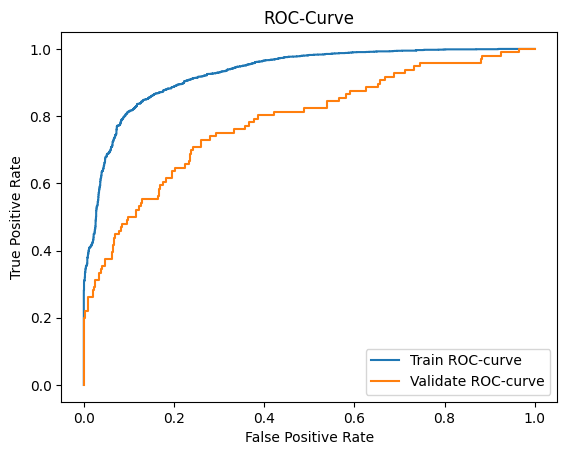

,accuracy,precision,recall,f1-score,roc-auc
Random Forest,0.860294,0.506024,0.4375,0.469274,0.784282


In [180]:
random_forest(rf_min_samples_split)

### Reduce Overfitting with min samples leaf

default = 1

In [181]:
min_samples_leaf = [1, 2, 5, 10, 15, 20, 50, 100, 150 ,200]

In [182]:
train_accuracy = []
train_precision = []
train_recall = []
train_f1 = []
train_roc_auc = []

val_accuracy = []
val_precision = []
val_recall = []
val_f1 = []
val_roc_auc = []
    
for i in min_samples_leaf:
    rf = RandomForestClassifier(random_state=8, n_estimators=50, max_depth=5, min_samples_split=50, min_samples_leaf=i).fit(X_train, y_train)
    y_train_preds = rf.predict(X_train)
    y_val_preds = rf.predict(X_val)
    
    y_train_probs = rf.predict_proba(X_train)[:, 1]
    y_val_probs = rf.predict_proba(X_val)[:, 1]
        
    train_accuracy.append(accuracy_score(y_train, y_train_preds))
    train_precision.append(precision_score(y_train, y_train_preds))
    train_recall.append(recall_score(y_train, y_train_preds))
    train_f1.append(f1_score(y_train, y_train_preds))
    train_roc_auc.append(roc_auc_score(y_train, y_train_probs))
    
    val_accuracy.append(accuracy_score(y_val, y_val_preds))
    val_precision.append(precision_score(y_val, y_val_preds))
    val_recall.append(recall_score(y_val, y_val_preds))
    val_f1.append(f1_score(y_val, y_val_preds))
    val_roc_auc.append(roc_auc_score(y_val, y_val_probs))
    
tune_min_samples_leaf = pd.DataFrame({'train_accuracy': train_accuracy,
                       'val_accuracy': val_accuracy,
                       'train_precision': train_precision,
                       'val_precision': val_precision,
                       'train_recall': train_recall,
                       'val_recall': val_recall,
                       'train_f1': train_f1,
                       'val_f1': val_f1,
                       'train_roc_auc': train_roc_auc,
                       'val_roc_auc': val_roc_auc}, index=min_samples_leaf)

tune_min_samples_leaf

,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_f1,val_f1,train_roc_auc,val_roc_auc
1,0.844311,0.860294,0.912398,0.506024,0.761762,0.437500,0.830303,0.469274,0.928967,0.784282
2,0.846022,0.861765,0.913177,0.511905,0.764756,0.447917,0.832402,0.477778,0.928889,0.783604
5,0.842814,0.858824,0.909974,0.500000,0.760907,0.447917,0.828791,0.472527,0.927711,0.781518
10,0.841531,0.861765,0.911386,0.512195,0.756630,0.437500,0.826829,0.471910,0.928862,0.781874
15,0.834260,0.858824,0.908094,0.500000,0.743798,0.437500,0.817776,0.466667,0.927894,0.780608
20,0.833618,0.857353,0.907950,0.493976,0.742515,0.427083,0.816941,0.458101,0.927430,0.780768
50,0.836399,0.854412,0.912861,0.482353,0.743798,0.427083,0.819703,0.453039,0.924703,0.768122
100,0.821001,0.816176,0.882323,0.359223,0.740804,0.385417,0.805394,0.371859,0.905760,0.760310
150,0.810950,0.814706,0.864594,0.375000,0.737382,0.468750,0.795937,0.416667,0.892961,0.766820
200,0.797690,0.810294,0.873391,0.336634,0.696322,0.354167,0.774869,0.345178,0.890610,0.767534


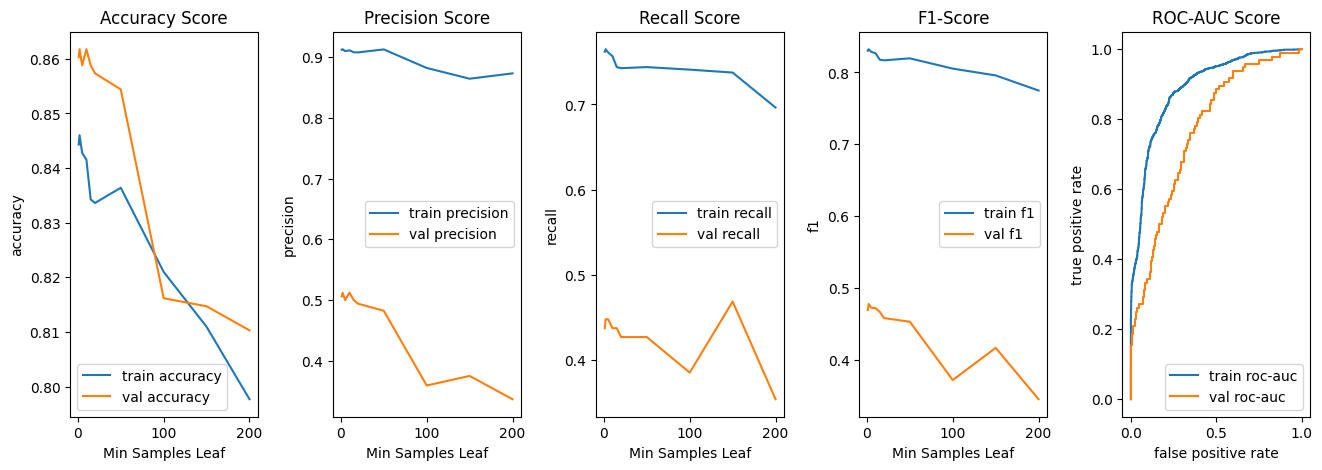

In [183]:
plot_performance(min_samples_leaf, 'Min Samples Leaf')

#### min_samples_leaf = 50

In [231]:
rf_min_samples_leaf = RandomForestClassifier(random_state=8, n_estimators=50, max_depth=5, min_samples_split=50, min_samples_leaf=2)
rf_min_samples_leaf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, min_samples_leaf=2, min_samples_split=50,
                       n_estimators=50, random_state=8)

                accuracy  precision    recall  f1-score   roc-auc
Training Set    0.901838   0.952756  0.316754  0.475442  0.865676
Validation Set  0.889706   0.888889  0.250000  0.390244  0.759275


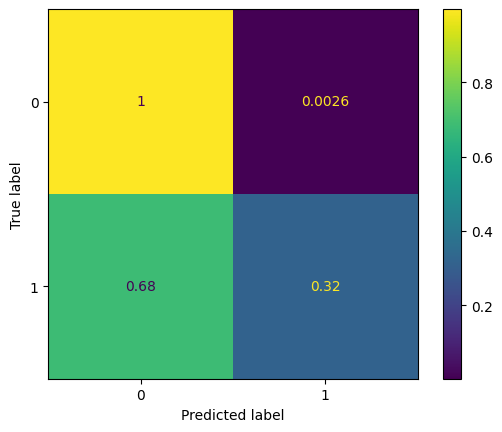

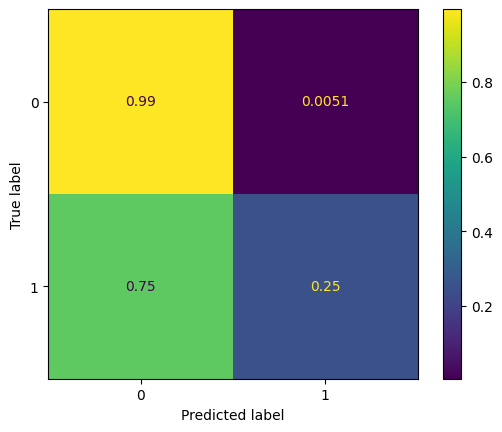

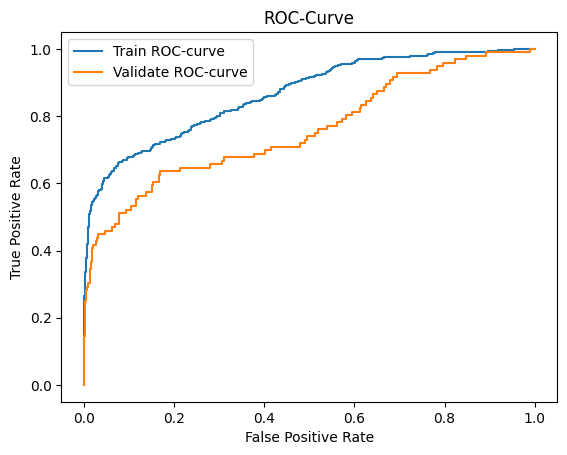

,accuracy,precision,recall,f1-score,roc-auc
Random Forest,0.889706,0.888889,0.25,0.390244,0.759275


In [232]:
random_forest(rf_min_samples_leaf)

### Reduce Overfitting with max_features

default = sqrt

In [91]:
max_features = ['auto', 'sqrt', 'log2', None]

In [186]:
train_accuracy = []
train_precision = []
train_recall = []
train_f1 = []
train_roc_auc = []

val_accuracy = []
val_precision = []
val_recall = []
val_f1 = []
val_roc_auc = []
    
for i in max_features:
    rf = RandomForestClassifier(random_state=8, n_estimators=50, max_depth=5, min_samples_split=50, min_samples_leaf=2, max_features=i).fit(X_train, y_train)
    y_train_preds = rf.predict(X_train)
    y_val_preds = rf.predict(X_val)
    
    y_train_probs = rf.predict_proba(X_train)[:, 1]
    y_val_probs = rf.predict_proba(X_val)[:, 1]
        
    train_accuracy.append(accuracy_score(y_train, y_train_preds))
    train_precision.append(precision_score(y_train, y_train_preds))
    train_recall.append(recall_score(y_train, y_train_preds))
    train_f1.append(f1_score(y_train, y_train_preds))
    train_roc_auc.append(roc_auc_score(y_train, y_train_probs))
    
    val_accuracy.append(accuracy_score(y_val, y_val_preds))
    val_precision.append(precision_score(y_val, y_val_preds))
    val_recall.append(recall_score(y_val, y_val_preds))
    val_f1.append(f1_score(y_val, y_val_preds))
    val_roc_auc.append(roc_auc_score(y_val, y_val_probs))
    
tune_max_features = pd.DataFrame({'train_accuracy': train_accuracy,
                       'val_accuracy': val_accuracy,
                       'train_precision': train_precision,
                       'val_precision': val_precision,
                       'train_recall': train_recall,
                       'val_recall': val_recall,
                       'train_f1': train_f1,
                       'val_f1': val_f1,
                       'train_roc_auc': train_roc_auc,
                       'val_roc_auc': val_roc_auc}, index=max_features)

tune_max_features

/Users/narongvatchingpayakmon/Projects/internship_c/internship_c_dataset_1/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_f1,val_f1,train_roc_auc,val_roc_auc
auto,0.846022,0.861765,0.913177,0.511905,0.764756,0.447917,0.832402,0.477778,0.928889,0.783604
sqrt,0.846022,0.861765,0.913177,0.511905,0.764756,0.447917,0.832402,0.477778,0.928889,0.783604
log2,0.857571,0.857353,0.916335,0.493671,0.786997,0.406250,0.846756,0.445714,0.931271,0.777683
None,0.798332,0.875000,0.956181,0.634146,0.625321,0.270833,0.756142,0.379562,0.900473,0.782008


### Reduce Overfitting with criterion

default = gini

In [188]:
criterion = ['gini', 'entropy', 'log_loss']

In [189]:
train_accuracy = []
train_precision = []
train_recall = []
train_f1 = []
train_roc_auc = []

val_accuracy = []
val_precision = []
val_recall = []
val_f1 = []
val_roc_auc = []
    
for i in criterion:
    rf = RandomForestClassifier(random_state=8, n_estimators=50, max_depth=5, min_samples_split=50, min_samples_leaf=2, max_features='sqrt', criterion=i).fit(X_train, y_train)
    y_train_preds = rf.predict(X_train)
    y_val_preds = rf.predict(X_val)
    
    y_train_probs = rf.predict_proba(X_train)[:, 1]
    y_val_probs = rf.predict_proba(X_val)[:, 1]
        
    train_accuracy.append(accuracy_score(y_train, y_train_preds))
    train_precision.append(precision_score(y_train, y_train_preds))
    train_recall.append(recall_score(y_train, y_train_preds))
    train_f1.append(f1_score(y_train, y_train_preds))
    train_roc_auc.append(roc_auc_score(y_train, y_train_probs))
    
    val_accuracy.append(accuracy_score(y_val, y_val_preds))
    val_precision.append(precision_score(y_val, y_val_preds))
    val_recall.append(recall_score(y_val, y_val_preds))
    val_f1.append(f1_score(y_val, y_val_preds))
    val_roc_auc.append(roc_auc_score(y_val, y_val_probs))
    
tune_criterion = pd.DataFrame({'train_accuracy': train_accuracy,
                       'val_accuracy': val_accuracy,
                       'train_precision': train_precision,
                       'val_precision': val_precision,
                       'train_recall': train_recall,
                       'val_recall': val_recall,
                       'train_f1': train_f1,
                       'val_f1': val_f1,
                       'train_roc_auc': train_roc_auc,
                       'val_roc_auc': val_roc_auc}, index=criterion)

tune_criterion

,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_f1,val_f1,train_roc_auc,val_roc_auc
gini,0.846022,0.861765,0.913177,0.511905,0.764756,0.447917,0.832402,0.477778,0.928889,0.783604
entropy,0.839607,0.864706,0.923693,0.526316,0.740376,0.416667,0.821937,0.465116,0.925671,0.772885
log_loss,0.839607,0.864706,0.923693,0.526316,0.740376,0.416667,0.821937,0.465116,0.925671,0.772885


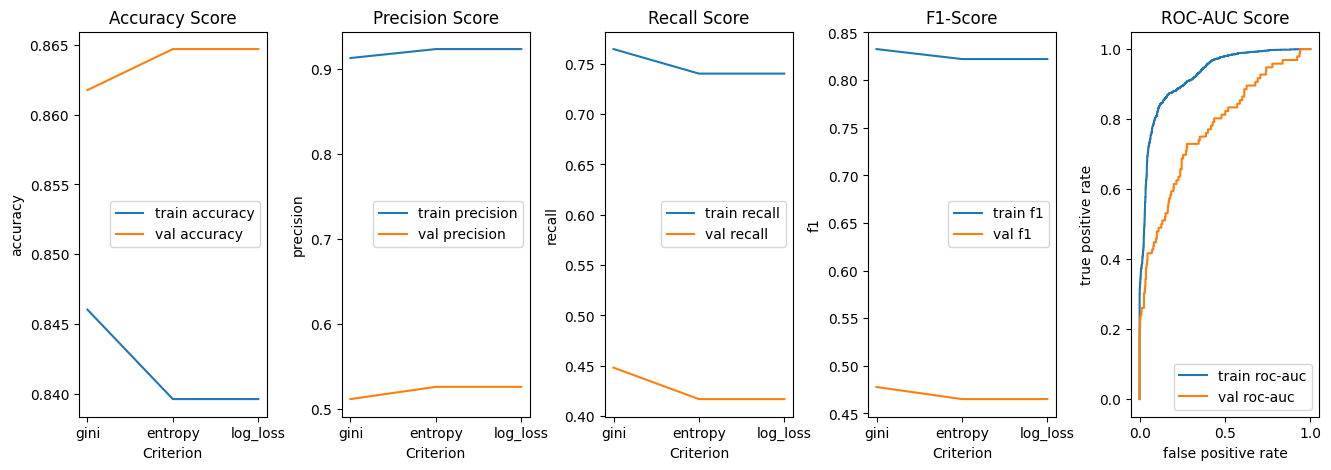

In [190]:
plot_performance(criterion, 'Criterion')

#### criterion = 'gini'

In [191]:
rf_criterion = RandomForestClassifier(random_state=8, n_estimators=50, max_depth=5, min_samples_split=50, min_samples_leaf=2, max_features='sqrt', criterion='gini')
rf_criterion.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, min_samples_leaf=2, min_samples_split=50,
                       n_estimators=50, random_state=8)

                accuracy  precision    recall  f1-score   roc-auc
Training Set    0.846022   0.913177  0.764756  0.832402  0.928889
Validation Set  0.861765   0.511905  0.447917  0.477778  0.783604


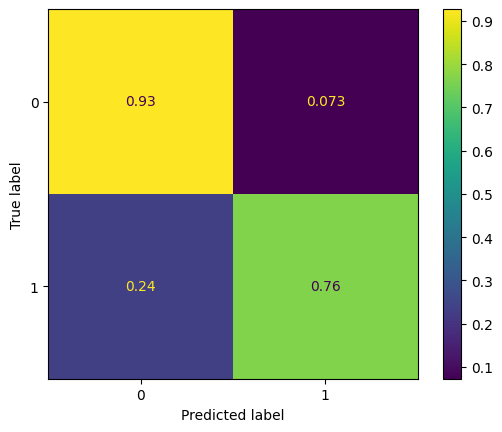

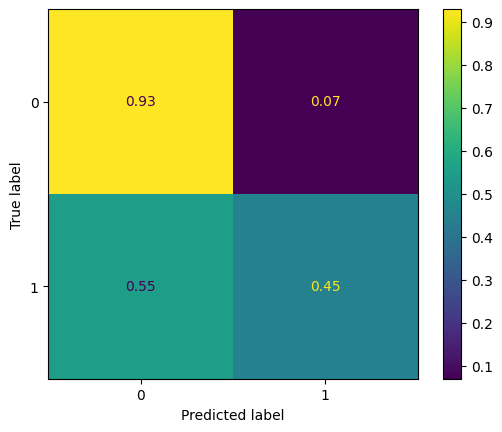

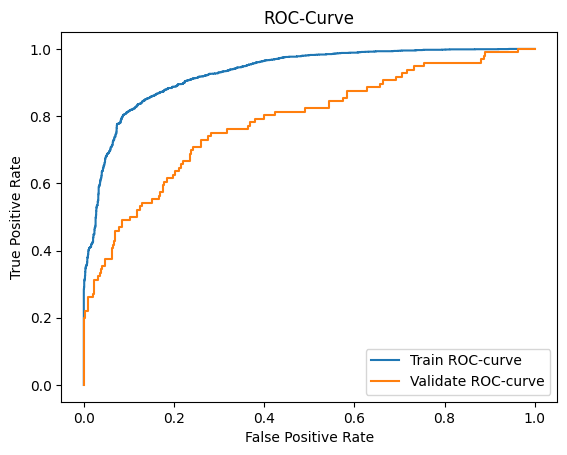

,accuracy,precision,recall,f1-score,roc-auc
Random Forest,0.861765,0.511905,0.447917,0.477778,0.783604


In [192]:
random_forest(rf_criterion)

### Reduce overfitting with Max Samples

In [193]:
max_samples = [0.5, 0.8, 1.0]

In [194]:
train_accuracy = []
train_precision = []
train_recall = []
train_f1 = []
train_roc_auc = []

val_accuracy = []
val_precision = []
val_recall = []
val_f1 = []
val_roc_auc = []
    
for i in max_samples:
    rf = RandomForestClassifier(random_state=8, n_estimators=50, max_depth=5, min_samples_split=50, min_samples_leaf=2, max_features='sqrt', criterion='gini', max_samples=i).fit(X_train, y_train)
    y_train_preds = rf.predict(X_train)
    y_val_preds = rf.predict(X_val)
    
    y_train_probs = rf.predict_proba(X_train)[:, 1]
    y_val_probs = rf.predict_proba(X_val)[:, 1]
        
    train_accuracy.append(accuracy_score(y_train, y_train_preds))
    train_precision.append(precision_score(y_train, y_train_preds))
    train_recall.append(recall_score(y_train, y_train_preds))
    train_f1.append(f1_score(y_train, y_train_preds))
    train_roc_auc.append(roc_auc_score(y_train, y_train_probs))
    
    val_accuracy.append(accuracy_score(y_val, y_val_preds))
    val_precision.append(precision_score(y_val, y_val_preds))
    val_recall.append(recall_score(y_val, y_val_preds))
    val_f1.append(f1_score(y_val, y_val_preds))
    val_roc_auc.append(roc_auc_score(y_val, y_val_probs))
    
tune_max_samples = pd.DataFrame({'train_accuracy': train_accuracy,
                       'val_accuracy': val_accuracy,
                       'train_precision': train_precision,
                       'val_precision': val_precision,
                       'train_recall': train_recall,
                       'val_recall': val_recall,
                       'train_f1': train_f1,
                       'val_f1': val_f1,
                       'train_roc_auc': train_roc_auc,
                       'val_roc_auc': val_roc_auc}, index=max_samples)

tune_max_samples

,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_f1,val_f1,train_roc_auc,val_roc_auc
0.5,0.829769,0.861765,0.923626,0.513158,0.718991,0.406250,0.808562,0.453488,0.927451,0.775917
0.8,0.835543,0.851471,0.913548,0.470588,0.741232,0.416667,0.818418,0.441989,0.931563,0.776345
1.0,0.846022,0.861765,0.913177,0.511905,0.764756,0.447917,0.832402,0.477778,0.928889,0.783604


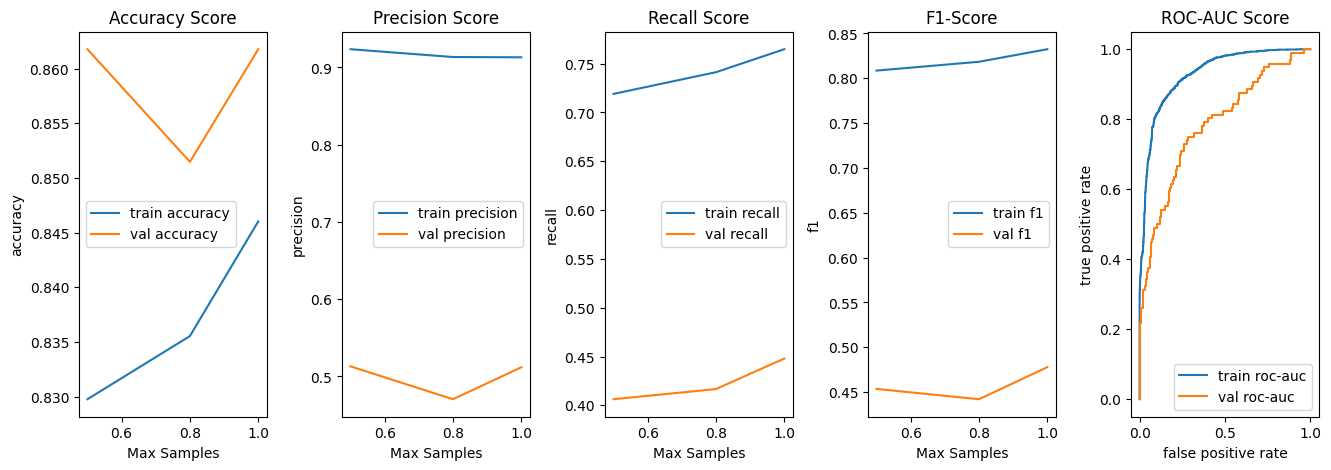

In [195]:
plot_performance(max_samples, 'Max Samples')

### Model After Hyperparameter Tuning

In [196]:
rf_tune = RandomForestClassifier(random_state=8, n_estimators=50, max_depth=5, min_samples_split=50, min_samples_leaf=2, max_features='sqrt', criterion='gini', max_samples=i)
rf_tune.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, max_samples=1.0, min_samples_leaf=2,
                       min_samples_split=50, n_estimators=50, random_state=8)

                accuracy  precision    recall  f1-score   roc-auc
Training Set    0.846022   0.913177  0.764756  0.832402  0.928889
Validation Set  0.861765   0.511905  0.447917  0.477778  0.783604


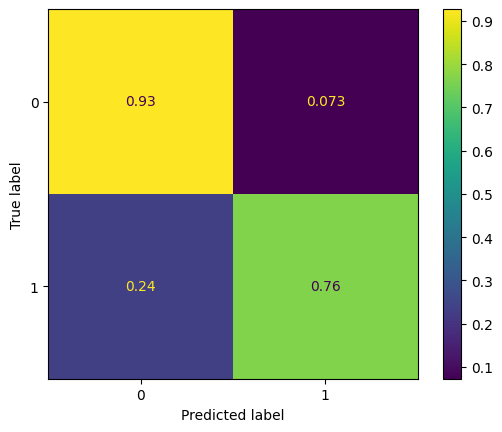

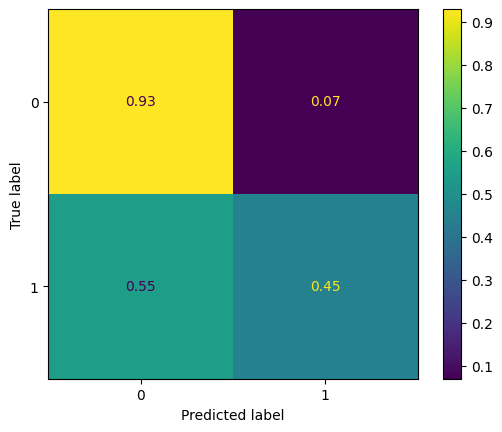

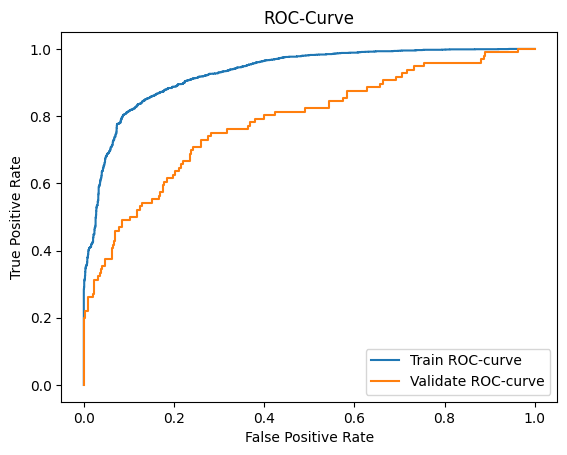

In [197]:
rf_smote = random_forest(rf_tune)

**True Positive**: Correctly predicted "churn"

**True Negative**: Correctly predicted "not churn"

**False Positive**: Predicted "churn", but actually "not churn"

**False Negative**: Predicted "not churn", but actually "churn"



- For churn prediction, we'll prioritize recall over precision since False Negative are more costly than False Positive.

- The high False Negative (61%) in the validation set suggest that the model might not be able to capture the actual churn customers and predicted as not churn.

In [198]:
rf_smote.to_csv('../data/processed/model/4_rf_smote.csv', index=False)

### Without SMOTE (use class_weight = 'balanced')

In [204]:
X_train = pd.read_csv('../data/processed/X_train.csv')
y_train = pd.read_csv('../data/processed/y_train.csv')
X_val = pd.read_csv('../data/processed/X_val.csv')
y_val = pd.read_csv('../data/processed/y_val.csv')
X_test = pd.read_csv('../data/processed/X_test.csv')
y_test = pd.read_csv('../data/processed/y_test.csv')

In [205]:
y_train = y_train.values.ravel()
y_val = y_val.values.ravel()
y_test = y_test.values.ravel()

In [206]:
rf = RandomForestClassifier(random_state=8, class_weight='balanced')
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=8)

                accuracy  precision    recall  f1-score   roc-auc
Training Set    1.000000   1.000000  1.000000  1.000000  1.000000
Validation Set  0.916176   0.953488  0.427083  0.589928  0.777736


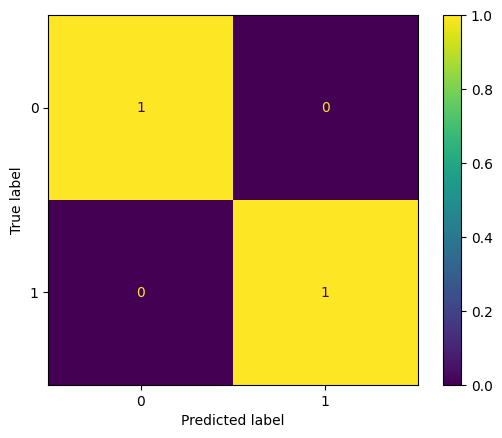

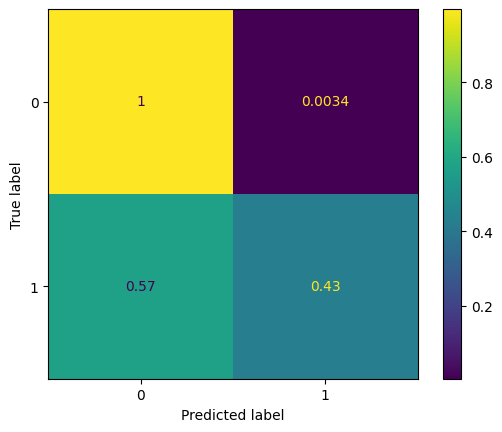

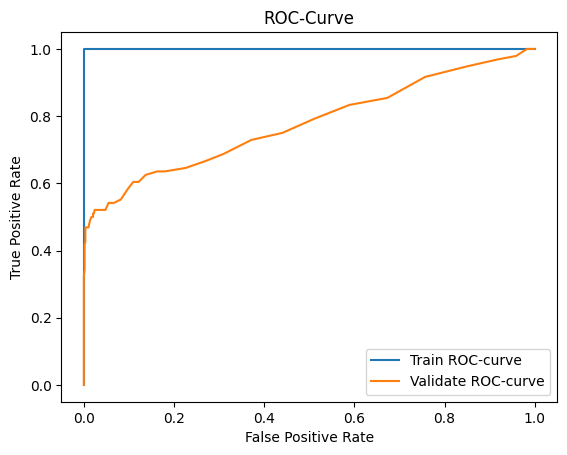

,accuracy,precision,recall,f1-score,roc-auc
Random Forest,0.916176,0.953488,0.427083,0.589928,0.777736


In [207]:
random_forest(rf)

### Reduce Overfitting with n_estimators

default = 100

In [208]:
n_estimators = [2, 5, 10, 20, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]

In [209]:
train_accuracy = []
train_precision = []
train_recall = []
train_f1 = []
train_roc_auc = []

val_accuracy = []
val_precision = []
val_recall = []
val_f1 = []
val_roc_auc = []
    
for i in n_estimators:
    rf = RandomForestClassifier(random_state=8, class_weight='balanced', n_estimators=i).fit(X_train, y_train)
    y_train_preds = rf.predict(X_train)
    y_val_preds = rf.predict(X_val)
    
    y_train_probs = rf.predict_proba(X_train)[:, 1]
    y_val_probs = rf.predict_proba(X_val)[:, 1]
        
    train_accuracy.append(accuracy_score(y_train, y_train_preds))
    train_precision.append(precision_score(y_train, y_train_preds))
    train_recall.append(recall_score(y_train, y_train_preds))
    train_f1.append(f1_score(y_train, y_train_preds))
    train_roc_auc.append(roc_auc_score(y_train, y_train_probs))
    
    val_accuracy.append(accuracy_score(y_val, y_val_preds))
    val_precision.append(precision_score(y_val, y_val_preds))
    val_recall.append(recall_score(y_val, y_val_preds))
    val_f1.append(f1_score(y_val, y_val_preds))
    val_roc_auc.append(roc_auc_score(y_val, y_val_probs))
    
tune_n_estimators = pd.DataFrame({'train_accuracy': train_accuracy,
                       'val_accuracy': val_accuracy,
                       'train_precision': train_precision,
                       'val_precision': val_precision,
                       'train_recall': train_recall,
                       'val_recall': val_recall,
                       'train_f1': train_f1,
                       'val_f1': val_f1,
                       'train_roc_auc': train_roc_auc,
                       'val_roc_auc': val_roc_auc}, index=n_estimators)

tune_n_estimators

,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_f1,val_f1,train_roc_auc,val_roc_auc
2,0.943382,0.888235,0.983051,0.794118,0.607330,0.281250,0.750809,0.415385,0.960630,0.702973
5,0.984559,0.902941,0.988506,0.800000,0.900524,0.416667,0.942466,0.547945,0.996986,0.764055
10,0.987868,0.898529,1.000000,0.885714,0.913613,0.322917,0.954856,0.473282,0.999855,0.792451
20,0.994853,0.908824,1.000000,0.972222,0.963351,0.364583,0.981333,0.530303,1.000000,0.794012
50,0.999632,0.914706,1.000000,0.975000,0.997382,0.406250,0.998689,0.573529,1.000000,0.773660
100,1.000000,0.916176,1.000000,0.953488,1.000000,0.427083,1.000000,0.589928,1.000000,0.777736
150,1.000000,0.913235,1.000000,0.951220,1.000000,0.406250,1.000000,0.569343,1.000000,0.790926
200,1.000000,0.914706,1.000000,0.952381,1.000000,0.416667,1.000000,0.579710,1.000000,0.788697
250,1.000000,0.914706,1.000000,0.952381,1.000000,0.416667,1.000000,0.579710,1.000000,0.799461
300,1.000000,0.914706,1.000000,0.952381,1.000000,0.416667,1.000000,0.579710,1.000000,0.799970


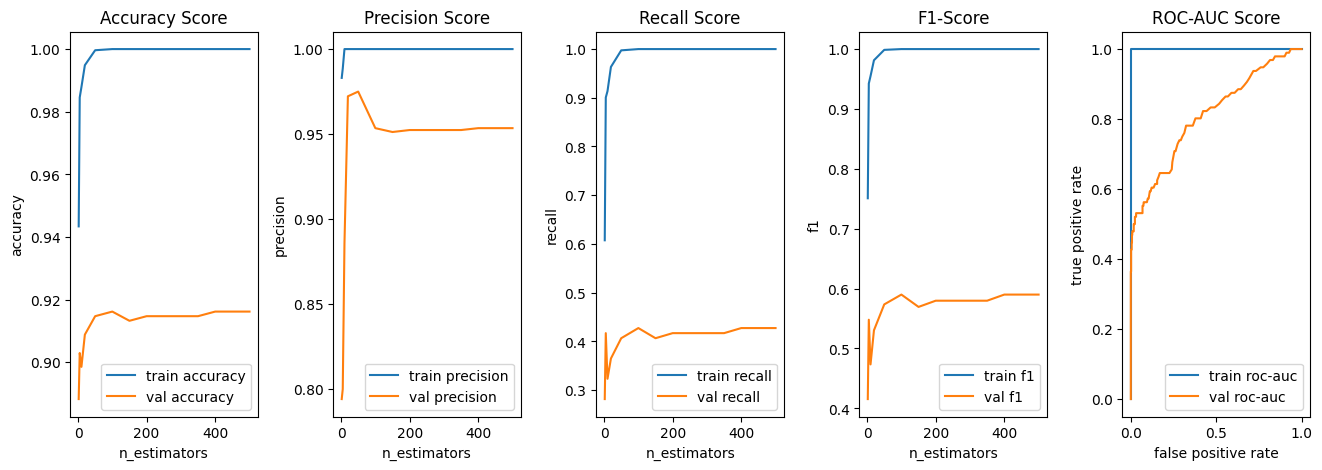

In [210]:
plot_performance(n_estimators, 'n_estimators')

### Reduce Overfitting with max_depth

default = None

In [171]:
max_depth = [2, 5, 10, 20, 50, 100, 150, 200, None]

In [215]:
train_accuracy = []
train_precision = []
train_recall = []
train_f1 = []
train_roc_auc = []

val_accuracy = []
val_precision = []
val_recall = []
val_f1 = []
val_roc_auc = []
    
for i in max_depth:
    rf = RandomForestClassifier(random_state=8, class_weight='balanced', n_estimators=400, max_depth=i).fit(X_train, y_train)
    y_train_preds = rf.predict(X_train)
    y_val_preds = rf.predict(X_val)
    
    y_train_probs = rf.predict_proba(X_train)[:, 1]
    y_val_probs = rf.predict_proba(X_val)[:, 1]
        
    train_accuracy.append(accuracy_score(y_train, y_train_preds))
    train_precision.append(precision_score(y_train, y_train_preds))
    train_recall.append(recall_score(y_train, y_train_preds))
    train_f1.append(f1_score(y_train, y_train_preds))
    train_roc_auc.append(roc_auc_score(y_train, y_train_probs))
    
    val_accuracy.append(accuracy_score(y_val, y_val_preds))
    val_precision.append(precision_score(y_val, y_val_preds))
    val_recall.append(recall_score(y_val, y_val_preds))
    val_f1.append(f1_score(y_val, y_val_preds))
    val_roc_auc.append(roc_auc_score(y_val, y_val_probs))
    
tune_max_depth = pd.DataFrame({'train_accuracy': train_accuracy,
                       'val_accuracy': val_accuracy,
                       'train_precision': train_precision,
                       'val_precision': val_precision,
                       'train_recall': train_recall,
                       'val_recall': val_recall,
                       'train_f1': train_f1,
                       'val_f1': val_f1,
                       'train_roc_auc': train_roc_auc,
                       'val_roc_auc': val_roc_auc}, index=max_depth)

tune_max_depth

,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_f1,val_f1,train_roc_auc,val_roc_auc
2.0,0.854412,0.833824,0.484848,0.422018,0.586387,0.479167,0.530806,0.448780,0.803912,0.749197
5.0,0.913971,0.888235,0.720238,0.635135,0.633508,0.489583,0.674095,0.552941,0.924696,0.818850
10.0,0.979779,0.917647,0.996960,0.934783,0.858639,0.447917,0.922644,0.605634,0.999609,0.845088
20.0,1.000000,0.917647,1.000000,0.954545,1.000000,0.437500,1.000000,0.600000,1.000000,0.807202
50.0,1.000000,0.916176,1.000000,0.953488,1.000000,0.427083,1.000000,0.589928,1.000000,0.807497
100.0,1.000000,0.916176,1.000000,0.953488,1.000000,0.427083,1.000000,0.589928,1.000000,0.807497
150.0,1.000000,0.916176,1.000000,0.953488,1.000000,0.427083,1.000000,0.589928,1.000000,0.807497
200.0,1.000000,0.916176,1.000000,0.953488,1.000000,0.427083,1.000000,0.589928,1.000000,0.807497
NaN,1.000000,0.916176,1.000000,0.953488,1.000000,0.427083,1.000000,0.589928,1.000000,0.807497


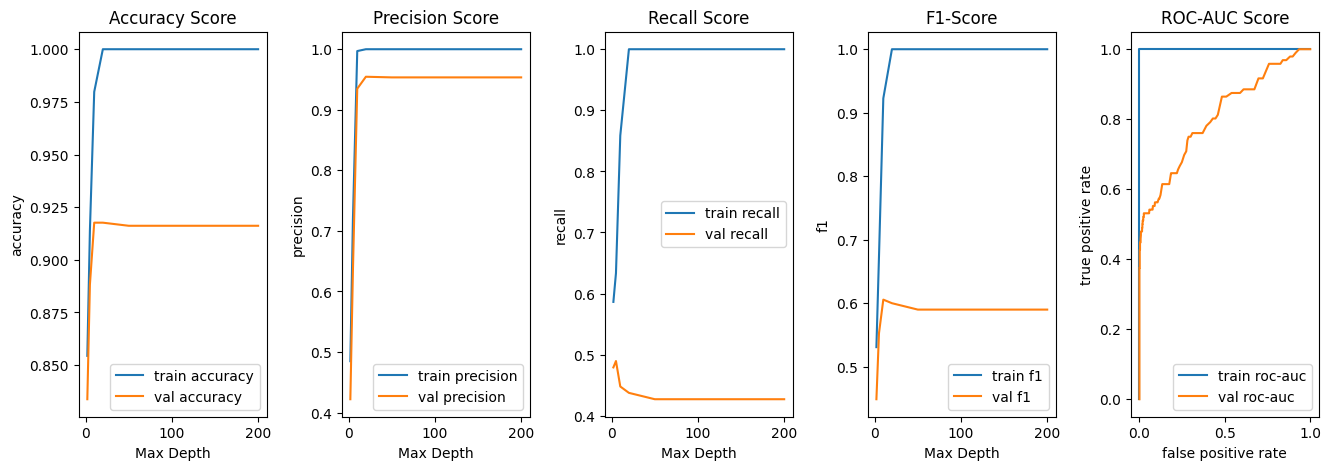

In [216]:
plot_performance(max_depth, 'Max Depth')

#### max_depth = 5

In [217]:
rf_max_depth = RandomForestClassifier(random_state=8, class_weight='balanced', n_estimators=400, max_depth=5)
rf_max_depth.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=400,
                       random_state=8)

                accuracy  precision    recall  f1-score   roc-auc
Training Set    0.913971   0.720238  0.633508  0.674095  0.924696
Validation Set  0.888235   0.635135  0.489583  0.552941  0.818850


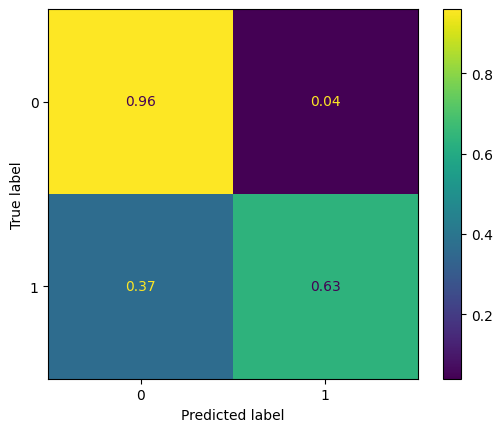

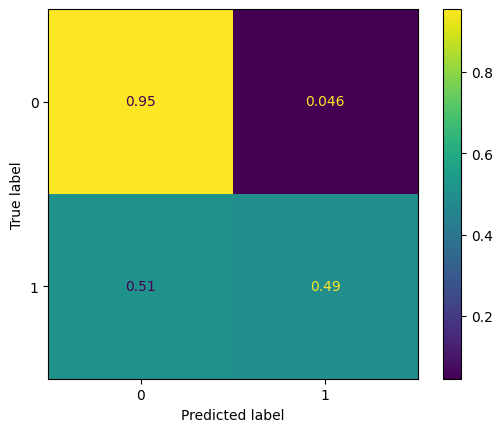

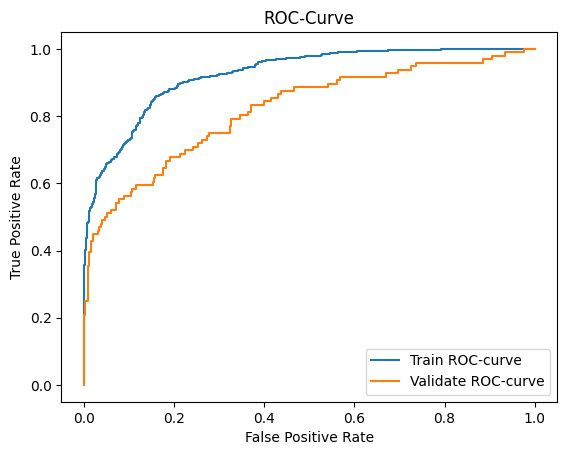

,accuracy,precision,recall,f1-score,roc-auc
Random Forest,0.888235,0.635135,0.489583,0.552941,0.81885


In [218]:
random_forest(rf_max_depth)

### Reduce Overfitting with min samples split

default = 2

In [222]:
min_samples_split = [2, 5, 10, 20, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]

In [223]:
train_accuracy = []
train_precision = []
train_recall = []
train_f1 = []
train_roc_auc = []

val_accuracy = []
val_precision = []
val_recall = []
val_f1 = []
val_roc_auc = []
    
for i in min_samples_split:
    rf = RandomForestClassifier(random_state=8, class_weight='balanced', n_estimators=400, max_depth=5, min_samples_split=i).fit(X_train, y_train)
    y_train_preds = rf.predict(X_train)
    y_val_preds = rf.predict(X_val)
    
    y_train_probs = rf.predict_proba(X_train)[:, 1]
    y_val_probs = rf.predict_proba(X_val)[:, 1]
        
    train_accuracy.append(accuracy_score(y_train, y_train_preds))
    train_precision.append(precision_score(y_train, y_train_preds))
    train_recall.append(recall_score(y_train, y_train_preds))
    train_f1.append(f1_score(y_train, y_train_preds))
    train_roc_auc.append(roc_auc_score(y_train, y_train_probs))
    
    val_accuracy.append(accuracy_score(y_val, y_val_preds))
    val_precision.append(precision_score(y_val, y_val_preds))
    val_recall.append(recall_score(y_val, y_val_preds))
    val_f1.append(f1_score(y_val, y_val_preds))
    val_roc_auc.append(roc_auc_score(y_val, y_val_probs))
    
tune_min_samples_split = pd.DataFrame({'train_accuracy': train_accuracy,
                       'val_accuracy': val_accuracy,
                       'train_precision': train_precision,
                       'val_precision': val_precision,
                       'train_recall': train_recall,
                       'val_recall': val_recall,
                       'train_f1': train_f1,
                       'val_f1': val_f1,
                       'train_roc_auc': train_roc_auc,
                       'val_roc_auc': val_roc_auc}, index=min_samples_split)

tune_min_samples_split

,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_f1,val_f1,train_roc_auc,val_roc_auc
2,0.913971,0.888235,0.720238,0.635135,0.633508,0.489583,0.674095,0.552941,0.924696,0.818850
5,0.913603,0.888235,0.716814,0.635135,0.636126,0.489583,0.674064,0.552941,0.925206,0.818725
10,0.913603,0.895588,0.714286,0.671233,0.641361,0.510417,0.675862,0.579882,0.923250,0.817798
20,0.909926,0.889706,0.699708,0.640000,0.628272,0.500000,0.662069,0.561404,0.918638,0.814872
50,0.901103,0.869118,0.653951,0.540230,0.628272,0.489583,0.640854,0.513661,0.904391,0.803742
100,0.879044,0.848529,0.562353,0.466019,0.625654,0.500000,0.592317,0.482412,0.888681,0.796233
150,0.845588,0.823529,0.462891,0.401639,0.620419,0.510417,0.530201,0.449541,0.874258,0.787636
200,0.836397,0.820588,0.441989,0.395161,0.628272,0.510417,0.518919,0.445455,0.861026,0.780073
250,0.832353,0.817647,0.433213,0.388889,0.628272,0.510417,0.512821,0.441441,0.851342,0.771832
300,0.830882,0.819118,0.430108,0.392000,0.628272,0.510417,0.510638,0.443439,0.844689,0.762878


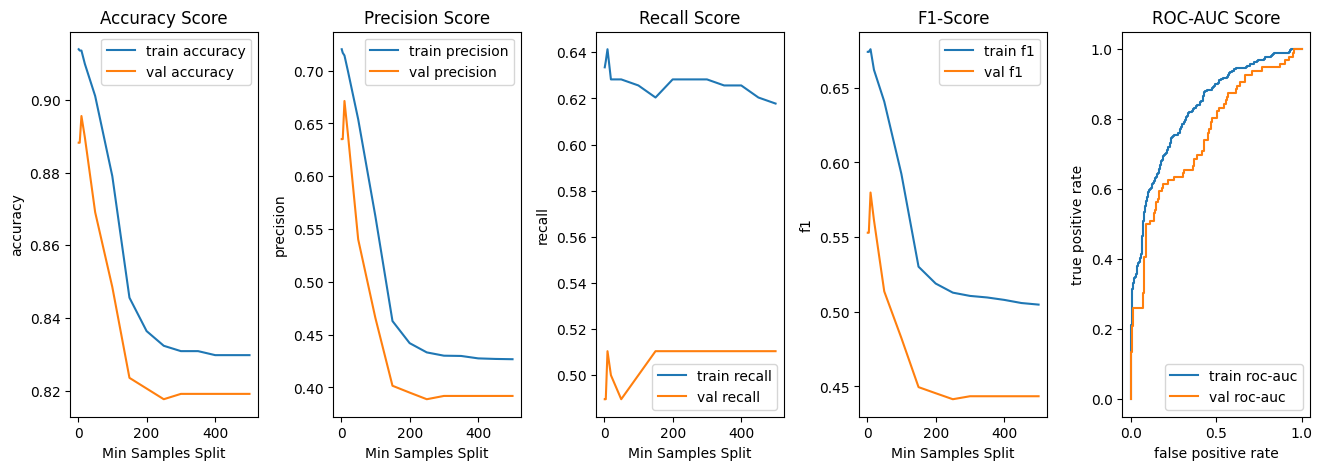

In [224]:
plot_performance(min_samples_split, 'Min Samples Split')

#### min_samples_split = 100

In [225]:
rf_min_samples_split = RandomForestClassifier(random_state=8, class_weight='balanced', n_estimators=400, max_depth=5, min_samples_split=100)
rf_min_samples_split.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5,
                       min_samples_split=100, n_estimators=400, random_state=8)

                accuracy  precision    recall  f1-score   roc-auc
Training Set    0.879044   0.562353  0.625654  0.592317  0.888681
Validation Set  0.848529   0.466019  0.500000  0.482412  0.796233


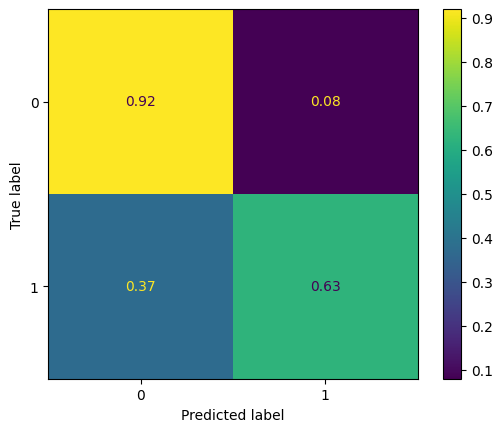

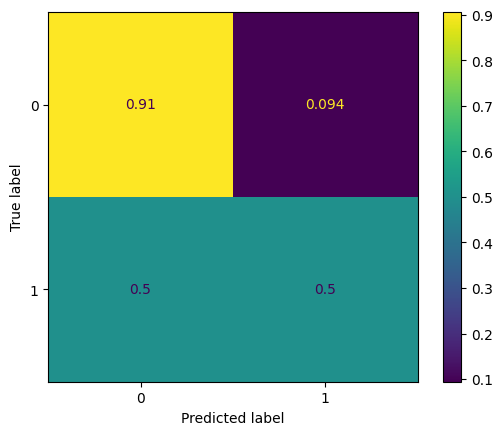

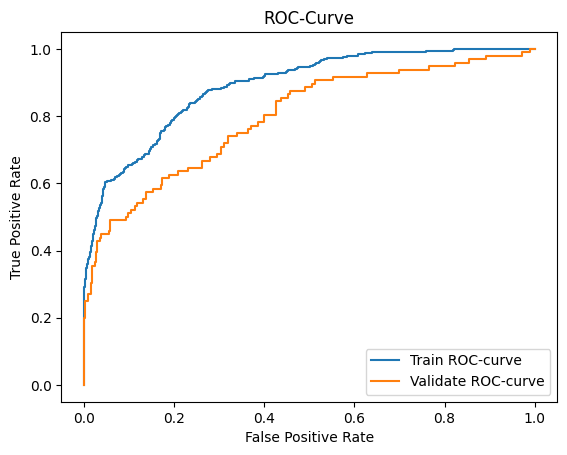

,accuracy,precision,recall,f1-score,roc-auc
Random Forest,0.848529,0.466019,0.5,0.482412,0.796233


In [226]:
random_forest(rf_min_samples_split)

### Reduce Overfitting with min samples leaf

default = 1

In [227]:
min_samples_leaf = [1, 2, 5, 10, 15, 20, 50, 100, 150 ,200]

In [228]:
train_accuracy = []
train_precision = []
train_recall = []
train_f1 = []
train_roc_auc = []

val_accuracy = []
val_precision = []
val_recall = []
val_f1 = []
val_roc_auc = []
    
for i in min_samples_leaf:
    rf = RandomForestClassifier(random_state=8, class_weight='balanced', n_estimators=400, max_depth=5, min_samples_split=100, min_samples_leaf=i).fit(X_train, y_train)
    y_train_preds = rf.predict(X_train)
    y_val_preds = rf.predict(X_val)
    
    y_train_probs = rf.predict_proba(X_train)[:, 1]
    y_val_probs = rf.predict_proba(X_val)[:, 1]
        
    train_accuracy.append(accuracy_score(y_train, y_train_preds))
    train_precision.append(precision_score(y_train, y_train_preds))
    train_recall.append(recall_score(y_train, y_train_preds))
    train_f1.append(f1_score(y_train, y_train_preds))
    train_roc_auc.append(roc_auc_score(y_train, y_train_probs))
    
    val_accuracy.append(accuracy_score(y_val, y_val_preds))
    val_precision.append(precision_score(y_val, y_val_preds))
    val_recall.append(recall_score(y_val, y_val_preds))
    val_f1.append(f1_score(y_val, y_val_preds))
    val_roc_auc.append(roc_auc_score(y_val, y_val_probs))
    
tune_min_samples_leaf = pd.DataFrame({'train_accuracy': train_accuracy,
                       'val_accuracy': val_accuracy,
                       'train_precision': train_precision,
                       'val_precision': val_precision,
                       'train_recall': train_recall,
                       'val_recall': val_recall,
                       'train_f1': train_f1,
                       'val_f1': val_f1,
                       'train_roc_auc': train_roc_auc,
                       'val_roc_auc': val_roc_auc}, index=min_samples_leaf)

tune_min_samples_leaf

,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_f1,val_f1,train_roc_auc,val_roc_auc
1,0.879044,0.848529,0.562353,0.466019,0.625654,0.500000,0.592317,0.482412,0.888681,0.796233
2,0.878676,0.848529,0.560748,0.466019,0.628272,0.500000,0.592593,0.482412,0.888567,0.795662
5,0.877941,0.850000,0.558411,0.471154,0.625654,0.510417,0.590123,0.490000,0.888328,0.795252
10,0.875368,0.847059,0.549425,0.462264,0.625654,0.510417,0.585067,0.485149,0.886415,0.792523
15,0.872794,0.842647,0.541096,0.449541,0.620419,0.510417,0.578049,0.478049,0.883614,0.791952
20,0.870588,0.841176,0.533482,0.445455,0.625654,0.510417,0.575904,0.475728,0.880545,0.789687
50,0.852941,0.829412,0.481928,0.418033,0.628272,0.531250,0.545455,0.467890,0.868660,0.770423
100,0.861397,0.841176,0.505330,0.445455,0.620419,0.510417,0.556992,0.475728,0.848595,0.762825
150,0.848529,0.829412,0.466368,0.401961,0.544503,0.427083,0.502415,0.414141,0.834343,0.740850
200,0.826471,0.795588,0.401747,0.299065,0.481675,0.333333,0.438095,0.315271,0.799163,0.704106


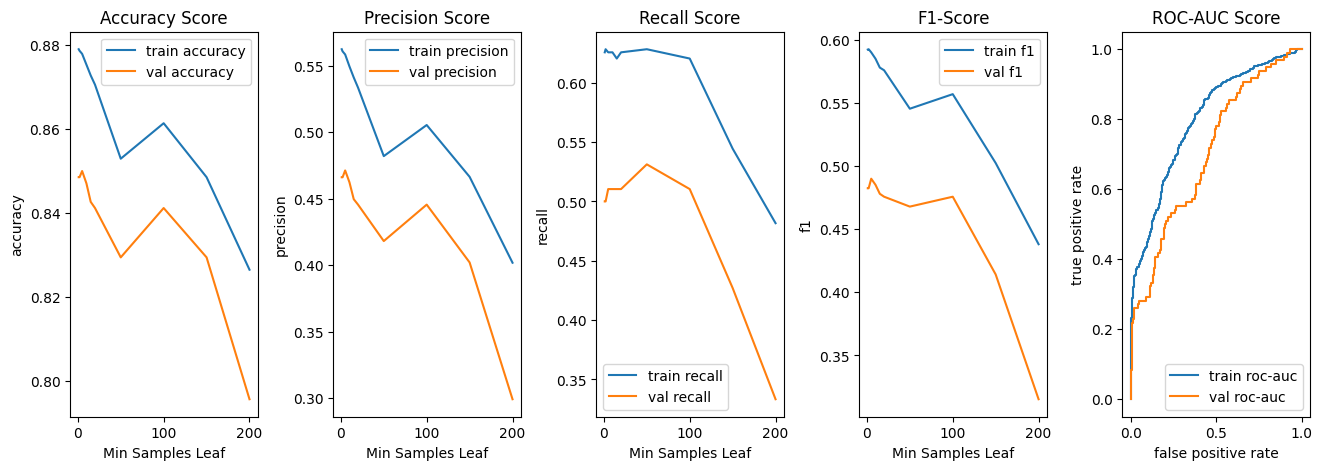

In [230]:
plot_performance(min_samples_leaf, 'Min Samples Leaf')

#### min_samples_leaf = 50

In [233]:
rf_min_samples_leaf = RandomForestClassifier(random_state=8, class_weight='balanced', n_estimators=400, max_depth=5, min_samples_split=100, min_samples_leaf=50)
rf_min_samples_leaf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5,
                       min_samples_leaf=50, min_samples_split=100,
                       n_estimators=400, random_state=8)

                accuracy  precision    recall  f1-score   roc-auc
Training Set    0.852941   0.481928  0.628272  0.545455  0.868660
Validation Set  0.829412   0.418033  0.531250  0.467890  0.770423


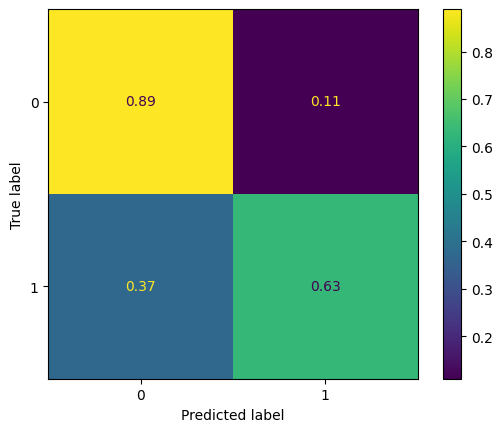

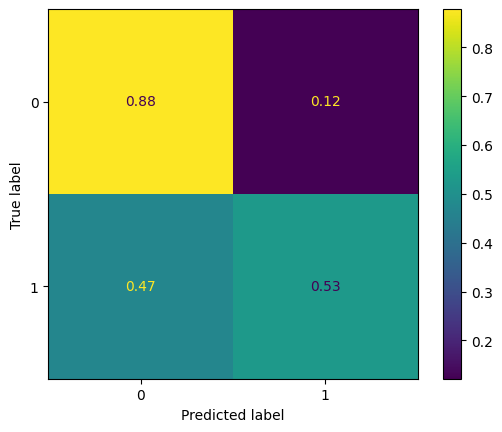

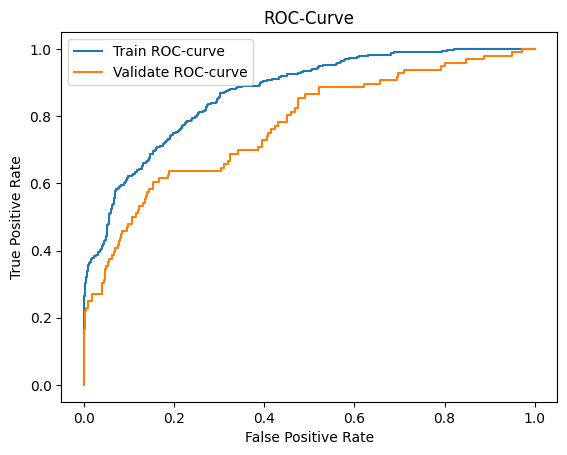

,accuracy,precision,recall,f1-score,roc-auc
Random Forest,0.829412,0.418033,0.53125,0.46789,0.770423


In [234]:
random_forest(rf_min_samples_leaf)

### Reduce Overfitting with max_features

default = sqrt

In [235]:
max_features = ['auto', 'sqrt', 'log2', None]

In [236]:
train_accuracy = []
train_precision = []
train_recall = []
train_f1 = []
train_roc_auc = []

val_accuracy = []
val_precision = []
val_recall = []
val_f1 = []
val_roc_auc = []
    
for i in max_features:
    rf = RandomForestClassifier(random_state=8, class_weight='balanced', n_estimators=400, max_depth=5, min_samples_split=100, min_samples_leaf=50, max_features=i).fit(X_train, y_train)
    y_train_preds = rf.predict(X_train)
    y_val_preds = rf.predict(X_val)
    
    y_train_probs = rf.predict_proba(X_train)[:, 1]
    y_val_probs = rf.predict_proba(X_val)[:, 1]
        
    train_accuracy.append(accuracy_score(y_train, y_train_preds))
    train_precision.append(precision_score(y_train, y_train_preds))
    train_recall.append(recall_score(y_train, y_train_preds))
    train_f1.append(f1_score(y_train, y_train_preds))
    train_roc_auc.append(roc_auc_score(y_train, y_train_probs))
    
    val_accuracy.append(accuracy_score(y_val, y_val_preds))
    val_precision.append(precision_score(y_val, y_val_preds))
    val_recall.append(recall_score(y_val, y_val_preds))
    val_f1.append(f1_score(y_val, y_val_preds))
    val_roc_auc.append(roc_auc_score(y_val, y_val_probs))
    
tune_max_features = pd.DataFrame({'train_accuracy': train_accuracy,
                       'val_accuracy': val_accuracy,
                       'train_precision': train_precision,
                       'val_precision': val_precision,
                       'train_recall': train_recall,
                       'val_recall': val_recall,
                       'train_f1': train_f1,
                       'val_f1': val_f1,
                       'train_roc_auc': train_roc_auc,
                       'val_roc_auc': val_roc_auc}, index=max_features)

tune_max_features

/Users/narongvatchingpayakmon/Projects/internship_c/internship_c_dataset_1/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_f1,val_f1,train_roc_auc,val_roc_auc
auto,0.852941,0.829412,0.481928,0.418033,0.628272,0.531250,0.545455,0.467890,0.868660,0.770423
sqrt,0.852941,0.829412,0.481928,0.418033,0.628272,0.531250,0.545455,0.467890,0.868660,0.770423
log2,0.857353,0.832353,0.493878,0.423729,0.633508,0.520833,0.555046,0.467290,0.866150,0.768639
None,0.831985,0.820588,0.430939,0.395161,0.612565,0.510417,0.505946,0.445455,0.865777,0.814828


### Reduce Overfitting with criterion

default = gini

In [188]:
criterion = ['gini', 'entropy', 'log_loss']

In [237]:
train_accuracy = []
train_precision = []
train_recall = []
train_f1 = []
train_roc_auc = []

val_accuracy = []
val_precision = []
val_recall = []
val_f1 = []
val_roc_auc = []
    
for i in criterion:
    rf = RandomForestClassifier(random_state=8, class_weight='balanced', n_estimators=400, max_depth=5, min_samples_split=100, min_samples_leaf=50, max_features='sqrt', criterion=i).fit(X_train, y_train)
    y_train_preds = rf.predict(X_train)
    y_val_preds = rf.predict(X_val)
    
    y_train_probs = rf.predict_proba(X_train)[:, 1]
    y_val_probs = rf.predict_proba(X_val)[:, 1]
        
    train_accuracy.append(accuracy_score(y_train, y_train_preds))
    train_precision.append(precision_score(y_train, y_train_preds))
    train_recall.append(recall_score(y_train, y_train_preds))
    train_f1.append(f1_score(y_train, y_train_preds))
    train_roc_auc.append(roc_auc_score(y_train, y_train_probs))
    
    val_accuracy.append(accuracy_score(y_val, y_val_preds))
    val_precision.append(precision_score(y_val, y_val_preds))
    val_recall.append(recall_score(y_val, y_val_preds))
    val_f1.append(f1_score(y_val, y_val_preds))
    val_roc_auc.append(roc_auc_score(y_val, y_val_probs))
    
tune_criterion = pd.DataFrame({'train_accuracy': train_accuracy,
                       'val_accuracy': val_accuracy,
                       'train_precision': train_precision,
                       'val_precision': val_precision,
                       'train_recall': train_recall,
                       'val_recall': val_recall,
                       'train_f1': train_f1,
                       'val_f1': val_f1,
                       'train_roc_auc': train_roc_auc,
                       'val_roc_auc': val_roc_auc}, index=criterion)

tune_criterion

,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_f1,val_f1,train_roc_auc,val_roc_auc
gini,0.852941,0.829412,0.481928,0.418033,0.628272,0.531250,0.545455,0.467890,0.868660,0.770423
entropy,0.852206,0.827941,0.479839,0.413223,0.623037,0.520833,0.542141,0.460829,0.869472,0.773990
log_loss,0.852206,0.827941,0.479839,0.413223,0.623037,0.520833,0.542141,0.460829,0.869472,0.773990


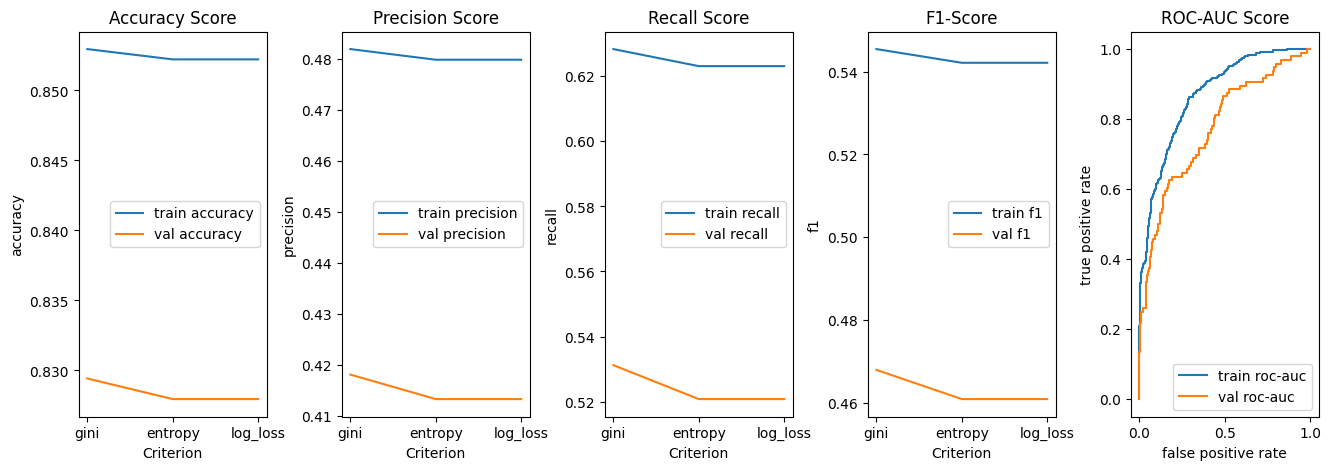

In [238]:
plot_performance(criterion, 'Criterion')

#### criterion = 'gini'

In [239]:
rf_criterion = RandomForestClassifier(random_state=8, class_weight='balanced', n_estimators=400, max_depth=5, min_samples_split=100, min_samples_leaf=50, max_features='sqrt', criterion='gini')
rf_criterion.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5,
                       min_samples_leaf=50, min_samples_split=100,
                       n_estimators=400, random_state=8)

                accuracy  precision    recall  f1-score   roc-auc
Training Set    0.852941   0.481928  0.628272  0.545455  0.868660
Validation Set  0.829412   0.418033  0.531250  0.467890  0.770423


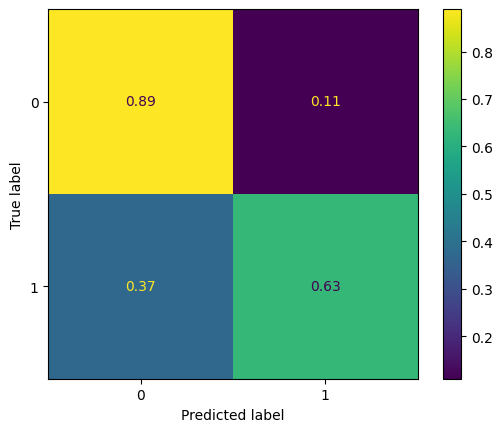

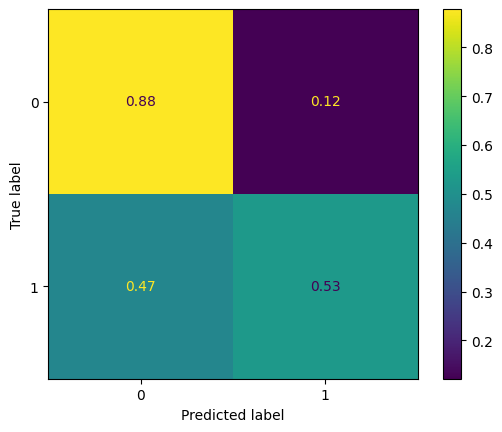

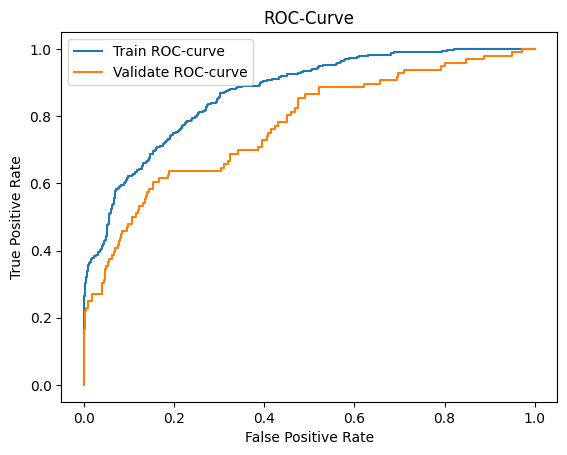

,accuracy,precision,recall,f1-score,roc-auc
Random Forest,0.829412,0.418033,0.53125,0.46789,0.770423


In [240]:
random_forest(rf_criterion)

### Reduce overfitting with Max Samples

In [241]:
max_samples = [0.5, 0.8, 1.0]

In [242]:
train_accuracy = []
train_precision = []
train_recall = []
train_f1 = []
train_roc_auc = []

val_accuracy = []
val_precision = []
val_recall = []
val_f1 = []
val_roc_auc = []
    
for i in max_samples:
    rf = RandomForestClassifier(random_state=8, class_weight='balanced', n_estimators=400, max_depth=5, min_samples_split=100, min_samples_leaf=50, max_features='sqrt', criterion='gini', max_samples=i).fit(X_train, y_train)
    y_train_preds = rf.predict(X_train)
    y_val_preds = rf.predict(X_val)
    
    y_train_probs = rf.predict_proba(X_train)[:, 1]
    y_val_probs = rf.predict_proba(X_val)[:, 1]
        
    train_accuracy.append(accuracy_score(y_train, y_train_preds))
    train_precision.append(precision_score(y_train, y_train_preds))
    train_recall.append(recall_score(y_train, y_train_preds))
    train_f1.append(f1_score(y_train, y_train_preds))
    train_roc_auc.append(roc_auc_score(y_train, y_train_probs))
    
    val_accuracy.append(accuracy_score(y_val, y_val_preds))
    val_precision.append(precision_score(y_val, y_val_preds))
    val_recall.append(recall_score(y_val, y_val_preds))
    val_f1.append(f1_score(y_val, y_val_preds))
    val_roc_auc.append(roc_auc_score(y_val, y_val_probs))
    
tune_max_samples = pd.DataFrame({'train_accuracy': train_accuracy,
                       'val_accuracy': val_accuracy,
                       'train_precision': train_precision,
                       'val_precision': val_precision,
                       'train_recall': train_recall,
                       'val_recall': val_recall,
                       'train_f1': train_f1,
                       'val_f1': val_f1,
                       'train_roc_auc': train_roc_auc,
                       'val_roc_auc': val_roc_auc}, index=max_samples)

tune_max_samples

,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_f1,val_f1,train_roc_auc,val_roc_auc
0.5,0.858456,0.836765,0.496842,0.433628,0.617801,0.510417,0.550758,0.468900,0.852077,0.758704
0.8,0.854044,0.830882,0.484848,0.420168,0.628272,0.520833,0.547320,0.465116,0.863254,0.771868
1.0,0.852941,0.829412,0.481928,0.418033,0.628272,0.531250,0.545455,0.467890,0.868660,0.770423


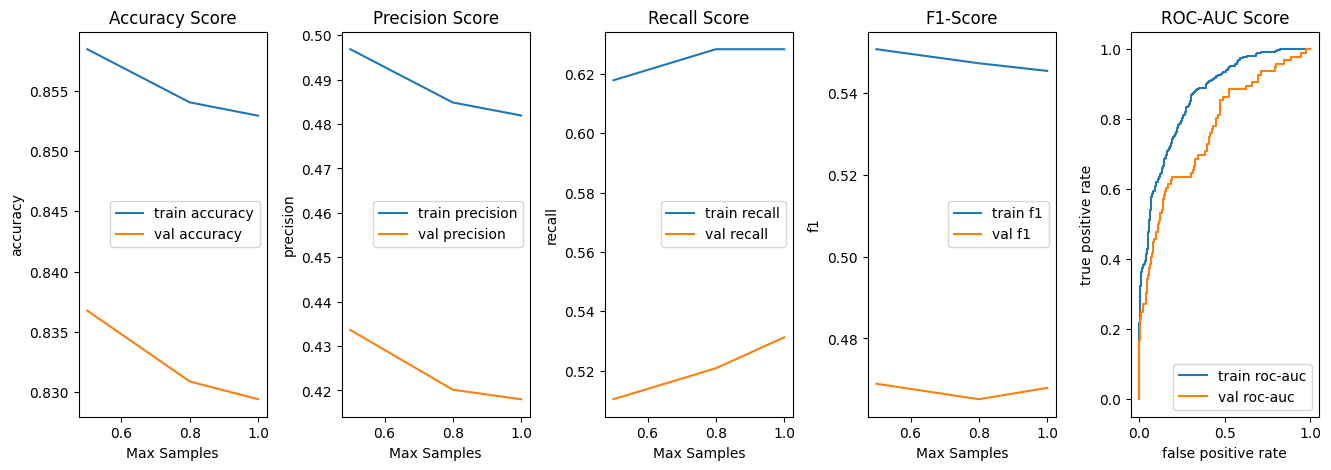

In [243]:
plot_performance(max_samples, 'Max Samples')

### Model After Hyperparameter Tuning

In [246]:
rf_tune = RandomForestClassifier(random_state=8, class_weight='balanced', n_estimators=400, max_depth=5, min_samples_split=100, min_samples_leaf=50, max_features='sqrt', criterion='gini')
rf_tune.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5,
                       min_samples_leaf=50, min_samples_split=100,
                       n_estimators=400, random_state=8)

                accuracy  precision    recall  f1-score   roc-auc
Training Set    0.852941   0.481928  0.628272  0.545455  0.868660
Validation Set  0.829412   0.418033  0.531250  0.467890  0.770423


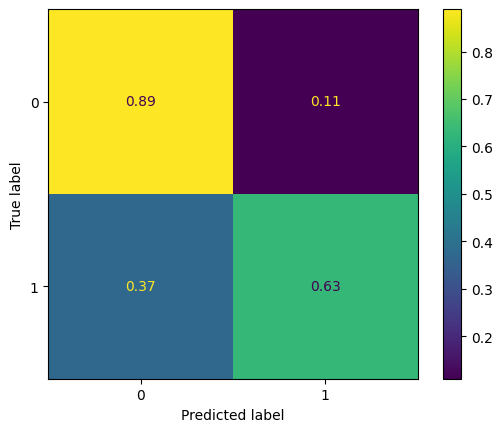

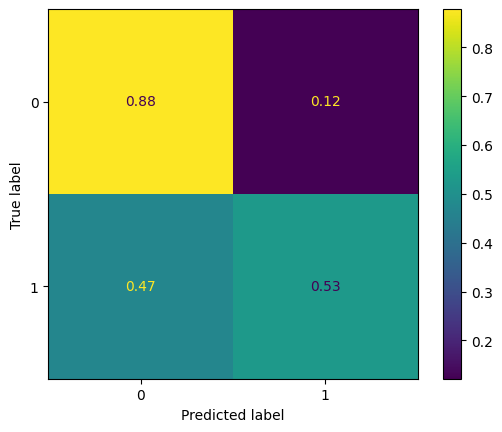

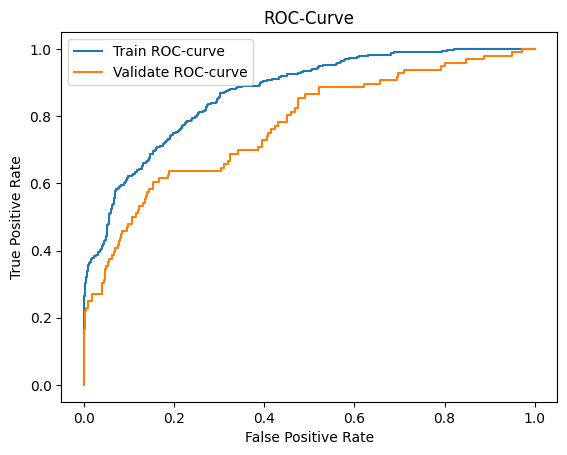

In [247]:
rf = random_forest(rf_tune)

**True Positive**: Correctly predicted "churn"

**True Negative**: Correctly predicted "not churn"

**False Positive**: Predicted "churn", but actually "not churn"

**False Negative**: Predicted "not churn", but actually "churn"



- For churn prediction, we'll prioritize recall over precision since False Negative are more costly than False Positive.

- The high False Negative (61%) in the validation set suggest that the model might not be able to capture the actual churn customers and predicted as not churn.

In [198]:
rf_smote.to_csv('../data/processed/model/4_rf_smote.csv', index=False)